# Making geologic cross sections from well logs

In [19]:
# let's import some packages we are going to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import lasio
from textwrap import wrap  # for making pretty well names

%matplotlib inline

### Where did this data come from?
The cell below reads in the LAS file names using glob, and then reads in some fake tops I made up for the cross section. These are close to the top of the Niobrara Formation in the Denver Basin of southeast Wyoming. Well log LAS files are from the [WOGCC](http://pipeline.wyo.gov/legacywogcce.cfm) and tops are eyeballed by me and are probably way off.

In [20]:
wells = []
for name in glob.glob("logs/2014/*.las"):
    wells.append(name)

Now let's create a figure and read in well log. We then plot each log by subsea depth so we can see a structural cross section

In [21]:
def get_depth(well_log):
    try:
        return well_log["DEPT"]
    except:
        return well_log["DEPTH"]

def get_gamma(well_log):
    try:
        return well_log["GR"]
    except:
        try:
            return well_log["GRGC"]
        except:
            try:
                return well_log["GAMMA"]
            except:
                return well_log["GAMMA:1"]

def get_well(well_log):
    try:
        return well_log.well["WELL"]
    except:
        return well_log.well["WELL:1"]

In [22]:
len(wells)

3231

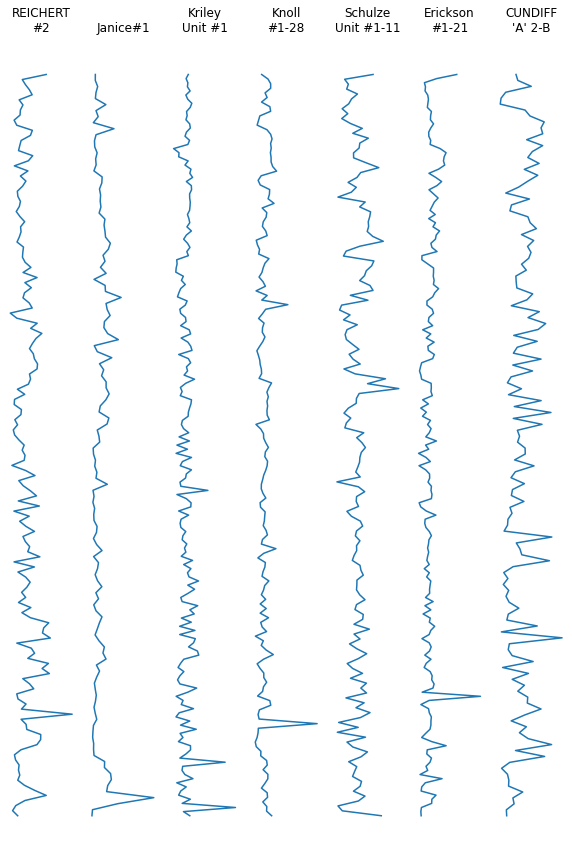

In [23]:
fig = plt.figure(figsize=(10, 15))  # set our figure size

for i, j in enumerate(range(21, 28)):  # we read in the 7 logs
    well_log = lasio.read(wells[j])  # this reads in the log
    ax = fig.add_subplot(
        171 + i
    )  # creates a subplot that the curve will be plotted in
    try:
        ax.plot(
            get_gamma(well_log)[::50],
            get_depth(well_log)[::50],
        )
    except Exception as e:
        print(e)
        print()
        pass
    # this does the plotting, we plot gamma ray as a function of depth. note we subtract the kelly bushing elevation (EKB) to get subsea depth
    # we also downsample the logs so they plot faster
    ax.invert_yaxis()
    # flip the axis so downhole is down in the figure
    ax.axis("off")
    # this gets rid of the axis so they look clean
    ax.set_title("\n".join(wrap(get_well(well_log).value, 10)))
    # and let's go ahead and add titles to each log for fun

That's a nice little cross section above, but can we make it better looking? More geologic styling to the gamma-ray curves is possible. Let's investigate this possibility. We will take our plot from above, and we're going to color between the curve and the right hand side. For a full breakdown look at the [coloring well logs notebook](https://github.com/jessepisel/5minutesofpython/blob/master/Well%20log%20plots/gamma%20ray%20colors.ipynb). One last thing we want to do is remove the whitespace between the logs so it looks better and we do that in the last line of the cell

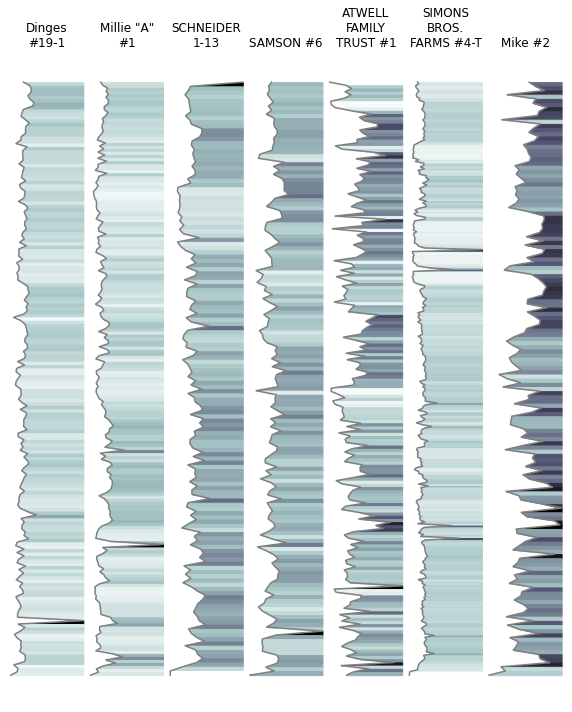

In [24]:
import matplotlib as mpl  # for making a colormap

cmap = mpl.cm.bone_r  # select our color map

fig = plt.figure(figsize=(10, 12))  # set our figure size


for i, j in enumerate(range(14, 21)):  # we read in the 7 logs
    well_log = lasio.read(wells[j])  # this reads in the log
    try:
        x = get_gamma(well_log)[::50]  # assign the GR values to x
        x[np.isnan(x)] = 0
        y = get_depth(well_log)[::50] #% assign the depth values to y
        z = (
             x
        )  # create a third variable for the colors, you could have fun and make this another curve as well
    except Exception as E:
        print(wells[i])
        print(E)
    normalize = mpl.colors.Normalize(vmin=z.min(), vmax=z.max())

    ax = fig.add_subplot(
        171 + i
    )  # creates a subplot that the curve will be plotted in
    ax.plot(x, y, color="gray")
    # this does the plotting, we plot gamma ray as a function of depth. note we subtract the kelly bushing elevation (EKB) to get subsea depth
    ax.invert_yaxis()
    # flip the axis so downhole is down in the figure

    for k in range(x.size - 1):
        plt.fill_betweenx(
            [y[k], y[k + 1]],
            [x[k], x[k + 1]],
            x2=z.max(),
            color=cmap(normalize(z[k])),
        )
    # let's plot the fake tops from the csv file as a horizontal line, don't forget to subtract the KB elevation for subsea depth
    ax.axis("off")
    # this gets rid of the axis so they look clean
    ax.set_title("\n".join(wrap(well_log.well["WELL"].value, 10)))
    # and let's go ahead and add titles to each log for fun
plt.subplots_adjust(wspace=0, hspace=0)

What else is in the well_log dataframe??

In [10]:
example_log = lasio.read(wells[0])
wells[0]

'logs/2014/1044839666.las'

Lets drop NaN's to see what is concistently there


In [11]:
example_df = example_log.df()
example_df

,BVTX,AVTX,RXORT,CILD,RLL3,SP,RILD,RILM,DCAL,RHOB,RHOC,DPOR,CNLS,GR,DGA,MCAL,MI,MN
DEPT,,,,,,,,,,,,,,,,,,
-1.0,0.0,0.0,NaN,NaN,100000.0,NaN,NaN,NaN,2.8636,-1.5648,-3.1316,249.9881,-4.9571,352.6158,NaN,NaN,NaN,NaN
-0.5,0.0,0.0,-28.7733,0.0000,50000.0,-333.0000,50000.0000,-499.6250,1.4312,-0.6938,-1.4650,119.8116,-2.4975,146.9875,NaN,NaN,NaN,NaN
0.0,0.0,0.0,-28.7733,0.0000,50000.0,-333.0000,50000.0000,-499.6250,1.4312,-0.6938,-1.4650,119.8116,-2.4975,146.9875,NaN,NaN,NaN,NaN
0.5,0.0,0.0,-392.5096,66.8215,100000.0,-999.0000,14.9652,NaN,2.8613,-0.7261,-2.3105,200.9407,-4.8093,253.7774,NaN,NaN,NaN,NaN
1.0,0.0,0.0,-403.8156,117.4983,100000.0,-999.0000,8.5108,NaN,2.8611,-0.2107,-1.7720,170.7992,-4.4559,235.1165,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4723.5,0.0,0.0,0.0000,0.0000,NaN,-50.2496,100000.0000,7.3005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9624,2.2530,3.7520
4724.0,0.0,0.0,0.0000,0.0000,NaN,-50.7174,100000.0000,7.5690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9617,2.2485,3.7498
4724.5,0.0,0.0,0.0000,0.0000,NaN,-51.2160,100000.0000,8.1534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9583,2.2406,3.7426


In [12]:
well_log.df().dropna()["GR"]

DEPT
2895.0     47.3903
2895.5     59.7958
2896.0     80.0829
2896.5     99.0036
2897.0    114.2536
            ...   
3720.5     26.1402
3721.0     24.6317
3721.5     24.4681
3722.0     25.1339
3722.5     26.9347
Name: GR, Length: 1656, dtype: float64

In [13]:
well_log.df()["GR"]

DEPT
195.0     68.4189
195.5     70.3969
196.0     69.9531
196.5     68.0556
197.0     66.9933
           ...   
3766.5        NaN
3767.0        NaN
3767.5        NaN
3768.0        NaN
3768.5        NaN
Name: GR, Length: 7148, dtype: float64

In [14]:
def plot_well(file_name):
    fig = plt.figure(figsize=(2,10))
    well_log = lasio.read(file_name)  # this reads in the log
    try:
        x = get_gamma(well_log)[::50]  # assign the GR values to x
        x[np.isnan(x)] = 0
        y = get_depth(well_log)[::50] #% assign the depth values to y
        z = (
            x
        )  # create a third variable for the colors, you could have fun and make this another curve as well
    except Exception as E:
        print(file_name)
        print(E)
        plt.close(fig)
        return
    normalize = mpl.colors.Normalize(vmin=z.min(), vmax=z.max())

    plt.plot(x, y, color="gray")
    ax = plt.gca()
    # this does the plotting, we plot gamma ray as a function of depth. note we subtract the kelly bushing elevation (EKB) to get subsea depth
    ax.invert_yaxis()
    # flip the axis so downhole is down in the figure

    for j in range(x.size - 1):
        plt.fill_betweenx(
            [y[j], y[j + 1]],
            [x[j], x[j + 1]],
            x2=z.max(),
            color=cmap(normalize(z[j])),
        )
    # let's plot the fake tops from the csv file as a horizontal line, don't forget to subtract the KB elevation for subsea depth
    ax.axis("off")
    # this gets rid of the axis so they look clean
    ax.set_title("\n".join(wrap(f'{get_well(well_log).value}', width=10)))
    # and let's go ahead and add titles to each log for fun
    well_name = get_well(well_log).value
    if type(well_name) == type([]):
        well_name = "".join(well_name)
    else:
        well_name = str(well_name)
    plt.savefig("well_figs/" + well_name.replace('/', '') + ".png", transparent=True)
    plt.close(fig)

logs/2014/1044761857.las
"GAMMA:1 not found in curves (['DEPT', '--:1', '--:2', '--:3'])"
logs/2014/1044913805.las
"GAMMA:1 not found in curves (['DEPT', 'PE', 'NPHI', 'DPHI'])"
logs/2014/1044913726.las
"GAMMA:1 not found in curves (['DEPT', 'NPHI', 'DPHI', 'PE'])"
logs/2014/1044839333.las
"GAMMA:1 not found in curves (['DEPT', 'ROPA', 'PGXR-T', 'PGTVD', 'PGVS'])"


KeyboardInterrupt: 

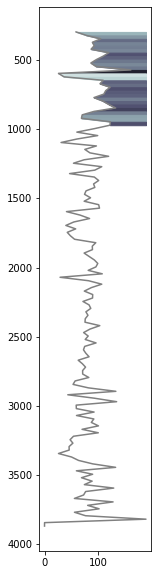

In [39]:
for i, well in enumerate(wells):
    plot_well(well)

In [15]:
def get_county(well_log):
    try:
        return well_log.well["CNTY"]
    except:
        return f"NA"

In [16]:
well_logs = []
for file in wells:
    well_logs.append(lasio.read(file))

/home/fastfist/.local/share/virtualenvs/transformers-kgQS_UHh/lib/python3.9/site-packages/lasio/las.py:284: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  arr[arr == provisional_null] = np.nan


ValueError: Cannot reshape ~A data size (697,) into 8 columns

Some of these Errored out when reading, we can skip over those for now and look at how many errors we have

In [18]:
errors = 1
stop = len(well_logs)
for i in range(stop+2, len(wells)):
    file = wells[i]
    try:
        well_logs.append(lasio.read(file))
    except Exception as e:
        print(f"{e} {errors}")
        errors += 1

Line 108 (section ~PARAMETER INFORMATION): "580-225-4300 :Remarks Line 8" 1
Line 100 (section ~PARAMETER INFORMATION): "Repeat Pass logged from 3150 to 2850 ft :Remarks Line 3" 2


In [30]:
counties = []
for well_log in well_logs:
    counties.append(get_county(well_log))

In [31]:
len(counties)

3227

In [32]:
for i, county in enumerate(counties):
    if type(county) != type(""):
        counties[i] = county.value
    
    counties[i] = counties[i].upper()

In [33]:
kwargs = dict(County=counties)

final_df = pd.DataFrame(kwargs)

In [34]:
final_df

,County
0,LOGAN
1,NESS
2,ELLIS
3,NESS
4,HODGEMAN
...,...
3222,GOVE
3223,NEMAHA
3224,ANDERSON
3225,GRAHAM


We found a bunch of typos...

In [35]:
corrections = {"HARPER CO": "HARPER", "SUMMER": "SUMNER", "SEDOWICK": "SEDGWICK", "ELLS": "ELLIS", "NESS CO.": "NESS", '': "NA"}
for key, value in corrections.items():
    final_df.loc[final_df["County"] == key] = value

In [36]:
freq_count = final_df["County"].value_counts()
freq_df = pd.DataFrame({"County": freq_count.keys(), "Frequency": freq_count.values})
freq_df = freq_df.sort_values(by="Frequency", ascending=False)
freq_df = freq_df.reset_index(drop=True)
freq_df

,County,Frequency
0,ELLIS,233
1,NESS,215
2,ANDERSON,199
3,BARBER,167
4,ROOKS,126
...,...,...
79,CHEROKEE,1
80,SHERMAN,1
81,RILEY,1
82,GREENWOOD,1


In [37]:
freq_df["Percent"] = freq_df['Frequency'] /freq_df["Frequency"].sum() * 100
freq_df

,County,Frequency,Percent
0,ELLIS,233,7.220328
1,NESS,215,6.662535
2,ANDERSON,199,6.166718
3,BARBER,167,5.175085
4,ROOKS,126,3.904555
...,...,...,...
79,CHEROKEE,1,0.030989
80,SHERMAN,1,0.030989
81,RILEY,1,0.030989
82,GREENWOOD,1,0.030989


<BarContainer object of 84 artists>

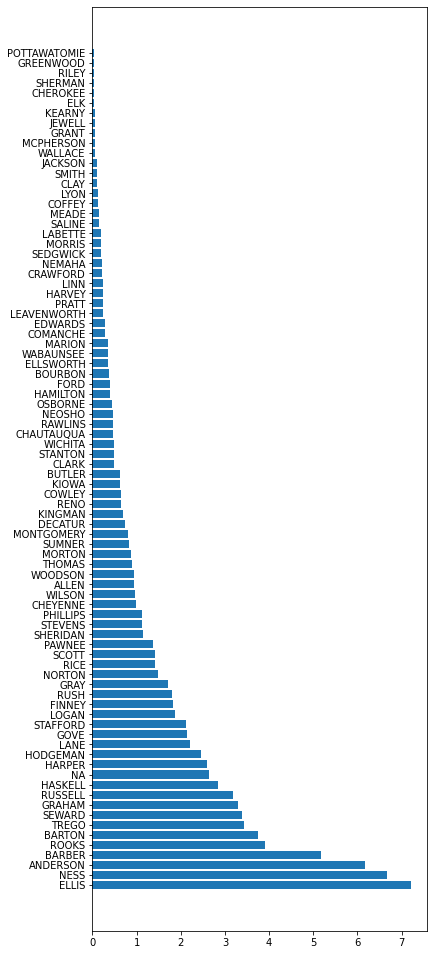

In [38]:
fig = plt.figure(figsize=(6,17))
plt.yticks(range(len(freq_df)), freq_df["County"])
plt.barh(range(len(freq_df)), freq_df["Percent"])

In [39]:
freq_df[freq_df["County"] == "NA"]

,County,Frequency,Percent
11,NA,85,2.634025


In [40]:
freq_df.head(10)

,County,Frequency,Percent
0,ELLIS,233,7.220328
1,NESS,215,6.662535
2,ANDERSON,199,6.166718
3,BARBER,167,5.175085
4,ROOKS,126,3.904555
5,BARTON,121,3.749613
6,TREGO,111,3.439727
7,SEWARD,109,3.377750
8,GRAHAM,106,3.284785
9,RUSSELL,103,3.191819


<AxesSubplot:>

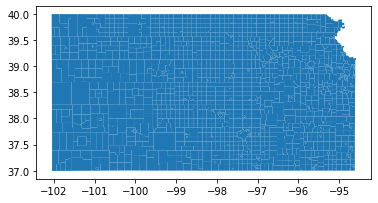

In [41]:
import geopandas as gpd
kansas_map = gpd.read_file("kansas.zip")
kansas_map.plot()

We want to find the county codes for each

In [42]:
fpis = pd.read_csv("fips.csv")
fpis

,fips,name,state
0,0,UNITED STATES,NaN
1,1000,ALABAMA,NaN
2,1001,Autauga County,AL
3,1003,Baldwin County,AL
4,1005,Barbour County,AL
...,...,...,...
3190,56037,Sweetwater County,WY
3191,56039,Teton County,WY
3192,56041,Uinta County,WY
3193,56043,Washakie County,WY


In [43]:
freq_df

,County,Frequency,Percent
0,ELLIS,233,7.220328
1,NESS,215,6.662535
2,ANDERSON,199,6.166718
3,BARBER,167,5.175085
4,ROOKS,126,3.904555
...,...,...,...
79,CHEROKEE,1,0.030989
80,SHERMAN,1,0.030989
81,RILEY,1,0.030989
82,GREENWOOD,1,0.030989


In [108]:
for index, county in freq_df["County"].iteritems():
    name = county.capitalize() + " County"
    if name == "Mcpherson County":
        name = "McPherson County"
    q1 = fpis[fpis["name"] == name]
    try:
        print(str(q1[q1["state"] == "KS"]["fips"].iloc[0])[2:])
        freq_df["COUNTYFP"][index] = str(q1[q1["state"] == "KS"]["fips"].iloc[0])[2:]
    except:
        print("None - " + county)

051
135
003
007
163
009
195
175
065
167
081
None - NA
077
083
101
063
185
109
055
165
069
137
159
171
145
179
189
147
023
205
001
207
193
129
191
125
039
095
155
035
097
015
025
187
203
019
153
133
141
075
057
011
053
197
115
033
047
103
151
079
107
037
131
173
127
099
169
119
031
111
027
183
085
199
113
067
089
093
049
021
181
161
073
149


<ipython-input-108-b17ea7ef453c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freq_df["COUNTYFP"][index] = str(q1[q1["state"] == "KS"]["fips"].iloc[0])[2:]


Now we can join the two together

<AxesSubplot:>

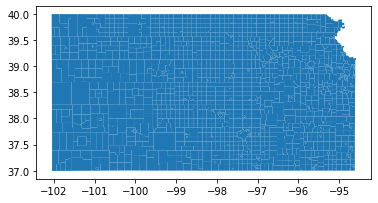

In [109]:
kansas_map.plot()

In [110]:
len(kansas_map)

1531

<AxesSubplot:>

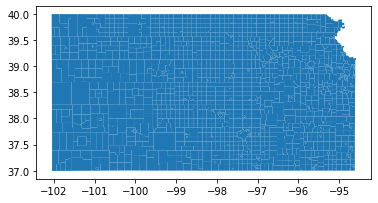

In [135]:
density_map = kansas_map
density_map = density_map.merge(freq_df[freq_df["County"] != "NA"], on = "COUNTYFP", how = "left")
density_map.plot()

In [136]:
density_map = density_map.fillna(0)

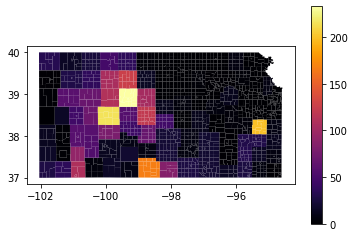

In [153]:
density_map.plot(column="Frequency", cmap = 'inferno', legend=True)
plt.savefig("kansas_map.png")

In [112]:
kansas_map["COUNTYFP"]

array(['139', '113', '161', '029', '093', '201', '193', '137', '035',
       '163', '003', '103', '071', '109', '063', '083', '065', '021',
       '105', '119', '055', '087', '005', '057', '147', '135', '133',
       '079', '039', '195', '197', '059', '191', '185', '125', '207',
       '089', '073', '111', '115', '123', '075', '041', '095', '001',
       '203', '177', '037', '205', '011', '121', '149', '159', '027',
       '019', '049', '017', '077', '031', '131', '171', '153', '091',
       '099', '127', '173', '107', '145', '155', '081', '043', '023',
       '143', '015', '101', '129', '033', '165', '157', '067', '179',
       '117', '209', '183', '061', '181', '025', '151', '175', '047',
       '045', '007', '199', '069', '097', '053', '189', '169', '187',
       '013', '051', '141', '009', '167', '085'], dtype=object)

In [113]:
freq_df["COUNTYFP"].unique()

array(['051', '135', '003', '007', '163', '009', '195', '175', '065',
       '167', '081', '149', '077', '083', '101', '063', '185', '109',
       '055', '165', '069', '137', '159', '171', '145', '179', '189',
       '147', '023', '205', '001', '207', '193', '129', '191', '125',
       '039', '095', '155', '035', '097', '015', '025', '187', '203',
       '019', '153', '133', '141', '075', '057', '011', '053', '197',
       '115', '033', '047', '103', '151', '079', '107', '037', '131',
       '173', '127', '099', '169', '119', '031', '111', '027', '183',
       '085', '199', '113', '067', '089', '093', '049', '021', '181',
       '161', '073'], dtype=object)